# Loading packages

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

Global seed set to 0


In [2]:
os.getcwd()

'/Volumes/T7/SCD/projects/visium-pipeline-development/code/zebrafish_heart_i001'

In [3]:
os.chdir("../..")

In [4]:
os.getcwd()

'/Volumes/T7/SCD/projects/visium-pipeline-development'

First, let's define where we save the results of our analysis:

In [7]:
results_folder = './output/cell2location/zebrafish_heart/SCD-VI-i001'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

# Loading Visium and scRNA-seq reference data

First let’s read spatial Visium data from 10X Space Ranger output. We rename genes to ENSEMBL ID for correct matching between single cell and spatial data - so you can ignore the scanpy suggestion to call .var_names_make_unique.

In [58]:
adata_vis = sc.read("./output/processed_data/SCD-VI-i001/SCD-VI-i001_subset.h5ad")
adata_vis

AnnData object with n_obs × n_vars = 454 × 32520
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial'
    var: '_index', 'features'

In [59]:
adata_vis.var

,_index,features
0,ptpn12,ptpn12
1,phtf2,phtf2
2,phtf2.1,phtf2.1
3,CU856344.1,CU856344.1
4,si:zfos-932h1.3,si:zfos-932h1.3
...,...,...
32515,CABZ01110379.1,CABZ01110379.1
32516,CABZ01054289.1,CABZ01054289.1
32517,CABZ01109604.1,CABZ01109604.1
32518,LAMP5,LAMP5


In [60]:
adata_vis.var.set_index('_index', drop=True, inplace=True)

Mitochondia-encoded genes (gene names start with prefix mt- or MT-) are irrelevant for spatial mapping because their expression represents technical artifacts in the single cell and nucleus data rather than biological abundance of mitochondria. Yet these genes compose 15-40% of mRNA in each location. Hence, to avoid mapping artifacts we strongly recommend removing mitochondrial genes.

In [61]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('mt-') for gene in adata_vis.var['features']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

Now we load the scRNA-seq data:

In [13]:
adata_ref = sc.read("./output/processed_data/SCD-VI-i001/zebrafish_heart_scrnaseq_subset.h5ad")

In [14]:
adata_ref

AnnData object with n_obs × n_vars = 96896 × 23466
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'time', 'morphine', 'AV', 'inhib', 'plot.ident2', 'nCount_RNA', 'nFeature_RNA'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'

In [15]:
adata_ref.var

,vst.mean,vst.variance,vst.variance.expected,vst.variance.standardized,vst.variable
dusp16,0.014383,0.015363,0.018556,0.827897,0
crebl2,0.031193,0.033800,0.042161,0.801682,0
gpr19,0.002250,0.002264,0.002687,0.842656,0
tbk1,0.052859,0.061536,0.077114,0.797989,0
eps8,0.012731,0.014419,0.016305,0.884331,0
...,...,...,...,...,...
pth1a,0.000010,0.000010,0.000010,0.989420,0
cacna2d4b,0.000020,0.000020,0.000020,0.969200,0
BX294110.1,0.000025,0.000025,0.000026,0.962246,0
sigirr,0.000010,0.000010,0.000010,0.989420,0


Here we rename genes to ENSEMBL ID for correct matching between single cell and spatial data.

In [16]:
adata_ref.var['SYMBOL'] = adata_ref.var_names

adata_ref.var

,vst.mean,vst.variance,vst.variance.expected,vst.variance.standardized,vst.variable,SYMBOL
dusp16,0.014383,0.015363,0.018556,0.827897,0,dusp16
crebl2,0.031193,0.033800,0.042161,0.801682,0,crebl2
gpr19,0.002250,0.002264,0.002687,0.842656,0,gpr19
tbk1,0.052859,0.061536,0.077114,0.797989,0,tbk1
eps8,0.012731,0.014419,0.016305,0.884331,0,eps8
...,...,...,...,...,...,...
pth1a,0.000010,0.000010,0.000010,0.989420,0,pth1a
cacna2d4b,0.000020,0.000020,0.000020,0.969200,0,cacna2d4b
BX294110.1,0.000025,0.000025,0.000026,0.962246,0,BX294110.1
sigirr,0.000010,0.000010,0.000010,0.989420,0,sigirr


Before we estimate the reference cell type signature we recommend to perform very permissive genes selection. We prefer this to standard highly-variable-gene selection because our procedure keeps markers of rare genes while removing most of the uninformative genes.

The default parameters cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12 are a good starting point, however, you can increase the cut-off to exclude more genes. To preserve marker genes of rare cell types we recommend low cell_count_cutoff=5, however, cell_percentage_cutoff2 and nonz_mean_cutoff can be increased to select between 8k-16k genes.




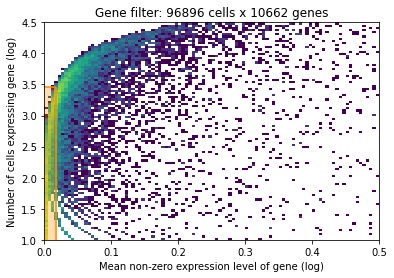

In [19]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.04)

# filter the object
adata_ref_filter = adata_ref[:, selected].copy()

In [20]:
adata_ref = adata_ref_filter
adata_ref

AnnData object with n_obs × n_vars = 96896 × 10662
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'time', 'morphine', 'AV', 'inhib', 'plot.ident2', 'nCount_RNA', 'nFeature_RNA'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'SYMBOL', 'n_cells', 'nonz_mean'

# Estimation of reference cell type signatures (NB regression)


In [21]:
inf_aver = cell2location.cluster_averages.cluster_averages.compute_cluster_averages(adata_ref, 'plot.ident2', use_raw=True, layer=None)

In [22]:
inf_aver

,B-cells,Bl.ves.EC (apnln),Bl.ves.EC (lyve1),Bl.ves.EC (plvapb),Cardiomyocytes (proliferating),Cardiomyocytes (ttn.2) A,Cardiomyocytes (ttn.2) V,Cardiomyocytes A,Cardiomyocytes V,Dead cells,...,Monocytes,Myelin cells,Neuronal cells,Neutrophils,Perivascular cells,Proliferating cells,Smooth muscle cells,T-cells,T-cells (il4/13),T-cells (proliferating)
dusp16,0.003643,0.003123,0.005284,0.007213,0.000000,0.010309,0.007092,0.001301,0.000769,0.0,...,0.036972,0.000000,0.000000,0.00818,0.000000,0.003448,0.008802,0.004471,0.026316,0.012658
crebl2,0.012750,0.014366,0.073976,0.070820,0.039711,0.024204,0.049645,0.014455,0.019908,0.0,...,0.031690,0.043210,0.641026,0.02863,0.034483,0.065517,0.061613,0.010730,0.000000,0.050633
gpr19,0.000000,0.000625,0.002642,0.001967,0.003610,0.004931,0.014184,0.001301,0.000854,0.0,...,0.000000,0.000000,0.025641,0.00000,0.002463,0.000000,0.005773,0.000596,0.000000,0.000000
tbk1,0.030965,0.008120,0.055482,0.054426,0.003610,0.032273,0.035461,0.006938,0.005639,0.0,...,0.042254,0.052469,0.256410,0.04090,0.017241,0.037931,0.038898,0.022355,0.026316,0.037975
eps8,0.000000,0.000000,0.006605,0.030820,0.007220,0.002689,0.003546,0.000434,0.001282,0.0,...,0.001761,0.006173,0.076923,0.00000,0.016010,0.034483,0.004921,0.000298,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pth1a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cacna2d4b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BX294110.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sigirr,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [62]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="orig.ident")


In [63]:
adata_vis

AnnData object with n_obs × n_vars = 454 × 22030
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'features', 'MT_gene'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'MT'

In [25]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=25,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'orig.ident',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │  454  │
│          n_vars          │ 22030 │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['orig.ident'] │     0      │          0          │
└─────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

Training cell2location:

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/emparbaltasarperez/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/Users/emparbaltasarperez/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 15000/15000: 100%|██████████████████████████████████████████████████████████████████████| 15000/15000 [5:17:56<00:00,  1.27s/it, v_num=1, elbo_train=2.86e+6]


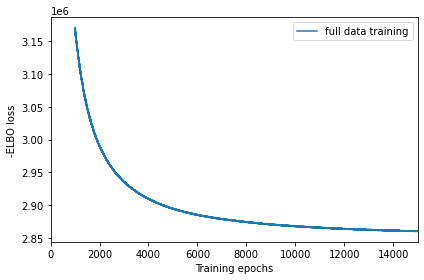

In [26]:
mod.train(max_epochs=15000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=False)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [70]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': False}
)


Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 999/999 [02:02<00:00,  8.13it/s]


In [75]:
adata_vis

AnnData object with n_obs × n_vars = 454 × 22030
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'features', 'MT_gene'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'stds_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf'

In [29]:
# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

In [99]:
adata_vis.var.index.names = ['gene']

In [107]:
adata_vis

AnnData object with n_obs × n_vars = 454 × 22030
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'features', 'MT_gene'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'mod'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'stds_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf'

In [101]:
# Save anndata object with results 
adata_file = "/Volumes/T7/SCD/projects/visium-pipeline-development/output/cell2location/zebrafish_heart/SCD-VI-i001/cell2location_map/sp.h5ad"
adata_vis.write(adata_file)


ValueError: '_index' is a reserved name for dataframe columns.

Above error raised while writing key 'var' of <class 'h5py._hl.group.Group'> to /

In [74]:
# Reload the data
adata_file = "/Volumes/T7/SCD/projects/visium-pipeline-development/output/cell2location/zebrafish_heart/SCD-VI-i001/cell2location_map/sp.h5ad"
adata_vis_2 = sc.read_h5ad(adata_file)
mod_2 = cell2location.models.Cell2location.load("/Volumes/T7/SCD/projects/visium-pipeline-development/output/cell2location/zebrafish_heart/SCD-VI-i001/cell2location_map", adata_vis_2)

INFO     File /Volumes/T7/SCD/projects/visium-pipeline-development/output/cell2location/zebra
         fish_heart/SCD-VI-i001/cell2location_map/model.pt already downloaded                


/Users/emparbaltasarperez/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_utils.py:134: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(


KeyError: 'orig.ident not found in adata.obs.'

In [67]:
adata_vis_2.obsm

AxisArrays with keys: MT

In [66]:
adata_vis

AnnData object with n_obs × n_vars = 454 × 22030
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'features', 'MT_gene'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'MT'

Assessing mapping quality. Examine reconstruction accuracy to assess if there are any issues with mapping. The plot should be roughly diagonal, strong deviations will signal problems that need to be investigated.


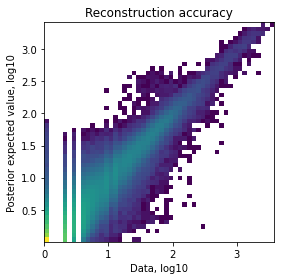

In [55]:
mod.plot_QC()


KeyError: 'spatial'

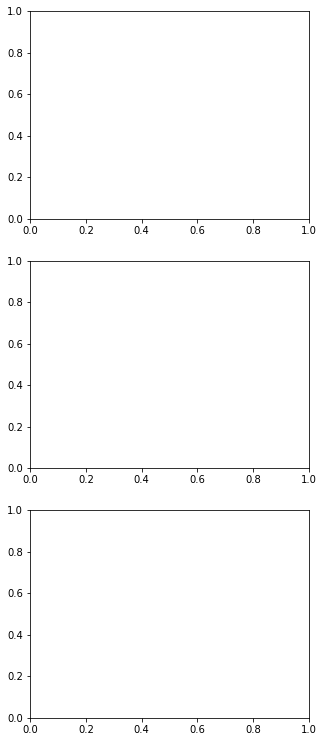

In [32]:
fig = mod.plot_spatial_QC_across_batches()

# Visualising cell abundance in spatial coordinates


In [52]:
adata_vis.obsm

AxisArrays with keys: MT, means_cell_abundance_w_sf, stds_cell_abundance_w_sf, q05_cell_abundance_w_sf, q95_cell_abundance_w_sf

In [51]:
adata_vis.obsm['means_cell_abundance_w_sf']

,meanscell_abundance_w_sf_B-cells,meanscell_abundance_w_sf_Bl.ves.EC (apnln),meanscell_abundance_w_sf_Bl.ves.EC (lyve1),meanscell_abundance_w_sf_Bl.ves.EC (plvapb),meanscell_abundance_w_sf_Cardiomyocytes (proliferating),meanscell_abundance_w_sf_Cardiomyocytes (ttn.2) A,meanscell_abundance_w_sf_Cardiomyocytes (ttn.2) V,meanscell_abundance_w_sf_Cardiomyocytes A,meanscell_abundance_w_sf_Cardiomyocytes V,meanscell_abundance_w_sf_Dead cells,...,meanscell_abundance_w_sf_Monocytes,meanscell_abundance_w_sf_Myelin cells,meanscell_abundance_w_sf_Neuronal cells,meanscell_abundance_w_sf_Neutrophils,meanscell_abundance_w_sf_Perivascular cells,meanscell_abundance_w_sf_Proliferating cells,meanscell_abundance_w_sf_Smooth muscle cells,meanscell_abundance_w_sf_T-cells,meanscell_abundance_w_sf_T-cells (il4/13),meanscell_abundance_w_sf_T-cells (proliferating)
AAACGAGACGGTTGAT-1,1.316686,0.253372,0.136665,0.126190,0.104832,0.067853,0.105381,0.158353,0.153234,0.198710,...,0.406890,0.404846,0.424212,1.713082,1.095742,0.170437,0.078803,0.541544,0.205046,1.024000
AAATTAACGGGTAGCT-1,1.213097,0.239459,0.689552,0.111882,0.027425,0.036351,0.017935,0.049934,0.034139,0.134245,...,0.481162,0.757634,0.472384,1.222476,1.235856,0.215613,0.110209,0.624335,0.204842,1.651417
AAATTACCTATCGATG-1,0.278998,0.333787,0.035851,0.109199,0.363972,1.414918,2.613040,8.902561,14.654849,0.256059,...,0.173699,0.068987,0.014092,0.618804,0.063775,0.080565,0.135722,0.201943,1.255023,0.062669
AACATATCAACTGGTG-1,0.195581,0.204003,0.019058,0.094030,0.314308,0.921844,1.622639,9.182092,15.361525,0.138984,...,0.272265,0.050024,0.019574,0.414287,0.050136,0.054274,0.092215,0.100616,1.304365,0.013479
AACCGAGCTTGGTCAT-1,2.588740,0.263631,0.914693,0.133487,0.042375,0.015061,0.012349,0.060872,0.043788,0.277456,...,0.215967,0.365595,0.514067,2.685443,0.808708,0.290579,0.066445,0.350785,0.239745,0.405315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGGACACTGCCCGC-1,0.087417,0.111456,0.029743,0.025975,0.029350,0.053769,0.067348,0.140330,0.196040,0.044467,...,0.040518,0.042869,0.018473,0.125016,0.079499,0.020704,0.030911,0.056487,0.054853,0.037262
TTGGGCGGCGGTTGCC-1,0.118166,0.109486,0.033099,0.037278,0.034392,0.043800,0.056042,0.143991,0.186793,0.057149,...,0.051884,0.053359,0.068457,0.153241,0.072321,0.024694,0.042481,0.077697,0.061497,0.042614
TTGTAAGGCCAGTTGG-1,0.595630,0.197037,0.215640,0.111623,0.065179,0.096060,0.319490,0.387959,0.420749,0.098608,...,0.266477,0.333451,0.213142,1.023589,0.531384,0.119823,0.100022,0.338534,0.179757,0.571908
TTGTTCAGTGTGCTAC-1,0.266551,0.235937,0.373208,0.235056,0.049082,0.036061,0.027177,0.073266,0.061652,0.087483,...,0.180609,0.144218,0.090204,0.954446,0.339829,0.073663,0.145528,0.224828,0.152105,0.497413


In [37]:
adata_vis.obsm['q05_cell_abundance_w_sf']

,q05cell_abundance_w_sf_B-cells,q05cell_abundance_w_sf_Bl.ves.EC (apnln),q05cell_abundance_w_sf_Bl.ves.EC (lyve1),q05cell_abundance_w_sf_Bl.ves.EC (plvapb),q05cell_abundance_w_sf_Cardiomyocytes (proliferating),q05cell_abundance_w_sf_Cardiomyocytes (ttn.2) A,q05cell_abundance_w_sf_Cardiomyocytes (ttn.2) V,q05cell_abundance_w_sf_Cardiomyocytes A,q05cell_abundance_w_sf_Cardiomyocytes V,q05cell_abundance_w_sf_Dead cells,...,q05cell_abundance_w_sf_Monocytes,q05cell_abundance_w_sf_Myelin cells,q05cell_abundance_w_sf_Neuronal cells,q05cell_abundance_w_sf_Neutrophils,q05cell_abundance_w_sf_Perivascular cells,q05cell_abundance_w_sf_Proliferating cells,q05cell_abundance_w_sf_Smooth muscle cells,q05cell_abundance_w_sf_T-cells,q05cell_abundance_w_sf_T-cells (il4/13),q05cell_abundance_w_sf_T-cells (proliferating)
AAACGAGACGGTTGAT-1,0.846659,0.048881,0.033938,0.038905,0.010435,0.007414,0.022383,0.013318,0.014788,0.061111,...,0.125436,0.147634,0.307722,1.185139,0.609726,0.056435,0.009923,0.161628,0.032634,0.738978
AAATTAACGGGTAGCT-1,0.741803,0.040911,0.387676,0.025676,0.001662,0.002737,0.000689,0.002830,0.001230,0.025949,...,0.157196,0.373058,0.346295,0.794534,0.668216,0.056197,0.013569,0.164431,0.032328,1.294362
AAATTACCTATCGATG-1,0.112542,0.062211,0.002399,0.025493,0.116957,1.004954,2.212950,7.478098,13.319016,0.072882,...,0.037567,0.004235,0.000621,0.380898,0.004971,0.007286,0.023275,0.024405,0.707113,0.006430
AACATATCAACTGGTG-1,0.063902,0.028775,0.000889,0.025516,0.116529,0.616511,1.307515,7.816612,14.233885,0.026311,...,0.097736,0.003056,0.001757,0.242968,0.002402,0.002486,0.012921,0.010035,0.806972,0.000476
AACCGAGCTTGGTCAT-1,1.964275,0.054898,0.575525,0.035143,0.004223,0.000981,0.000537,0.003421,0.002129,0.112010,...,0.066804,0.129347,0.387792,2.030107,0.403529,0.111455,0.008892,0.097252,0.044148,0.212687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGGACACTGCCCGC-1,0.009752,0.002351,0.000782,0.000931,0.000346,0.001116,0.004867,0.016439,0.035607,0.001654,...,0.001902,0.001077,0.000618,0.022083,0.002774,0.000307,0.000478,0.002239,0.001915,0.001362
TTGGGCGGCGGTTGCC-1,0.014702,0.003249,0.000700,0.001546,0.000365,0.001019,0.003220,0.017025,0.029536,0.002064,...,0.002886,0.001415,0.005754,0.031252,0.003010,0.000432,0.000801,0.003499,0.002505,0.002211
TTGTAAGGCCAGTTGG-1,0.291097,0.021156,0.055587,0.029289,0.003859,0.017697,0.173273,0.078411,0.128990,0.025480,...,0.060780,0.100080,0.126544,0.622493,0.212663,0.023260,0.009610,0.076354,0.024729,0.310131
TTGTTCAGTGTGCTAC-1,0.086362,0.028494,0.120875,0.073159,0.002223,0.002172,0.001231,0.003998,0.003582,0.012827,...,0.032949,0.018357,0.020444,0.548176,0.066837,0.008766,0.019421,0.031482,0.014806,0.227014


In [38]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

In [136]:
# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, 'V1_Mouse_Brain_Sagittal_Anterior')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=adata_vis.uns['mod']['factor_names'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )


KeyError: 'sample'

In [139]:
adata_vis.obs[adata_vis.uns['mod']['factor_names']]

,B-cells,Bl.ves.EC (apnln),Bl.ves.EC (lyve1),Bl.ves.EC (plvapb),Cardiomyocytes (proliferating),Cardiomyocytes (ttn.2) A,Cardiomyocytes (ttn.2) V,Cardiomyocytes A,Cardiomyocytes V,Dead cells,...,Monocytes,Myelin cells,Neuronal cells,Neutrophils,Perivascular cells,Proliferating cells,Smooth muscle cells,T-cells,T-cells (il4/13),T-cells (proliferating)
AAACAAGTATCTCCCA-1,0.026951,0.296695,0.110696,0.026757,0.701667,2.999252,6.454447,0.966585,0.957577,0.032057,...,0.014995,0.037341,0.012612,0.176748,0.334318,1.156188,0.176744,0.224892,0.056913,0.076203
AAATCTAGCCCTGCTA-1,0.051467,0.021885,0.007245,0.076757,0.804216,2.799509,1.745676,2.211748,6.051983,0.000899,...,0.005346,0.008824,0.000241,0.002465,0.011399,0.004152,0.009345,0.016358,0.004972,0.007445
AACACACGCTCGCCGC-1,0.013729,0.390010,0.488153,0.090502,0.175964,0.685351,2.423648,0.259880,0.250789,1.111558,...,0.020472,0.003757,0.000917,3.023039,0.477922,0.330480,0.012194,0.975087,0.242331,0.362085
AACCCGAGCAGAATCG-1,0.101771,0.069072,0.036833,0.281715,1.079400,3.657352,5.235313,1.415612,3.059782,0.028907,...,0.073597,0.098606,0.005960,0.009405,0.076488,0.029143,0.125278,0.036818,0.008829,0.012349
AACGCTGTTGCTGAAA-1,0.023475,0.265445,0.023039,0.044025,2.535028,2.159650,10.166799,1.151912,2.008070,0.074700,...,0.012205,0.011596,0.006600,0.051325,0.081835,0.764965,0.029850,0.087637,0.051183,0.022262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCCATCGACAGCGTG-1,0.047352,0.078636,0.018772,0.044372,1.024823,2.997654,2.256883,1.431469,2.865060,0.003585,...,0.034189,0.056745,0.028837,0.008878,0.030286,0.020617,0.075244,0.027344,0.011732,0.006016
TTCTTATCCGCTGGGT-1,0.038491,0.377010,0.075455,1.139792,0.712695,1.811077,3.460703,0.692393,0.961487,0.054763,...,0.025252,0.013749,0.000597,0.282793,0.493571,0.289658,0.031470,0.390284,0.045844,0.198456
TTGGACCATCTGGCAA-1,0.027529,0.016427,0.005526,0.011626,0.461808,1.805856,0.921905,1.133352,3.162218,0.000987,...,0.010854,0.005333,0.000123,0.002703,0.009178,0.003351,0.009032,0.010798,0.003612,0.003212
TTGGCTCAATATGTGT-1,0.021664,0.053761,0.020896,0.011175,0.566642,6.599885,0.577405,1.569070,0.945944,0.001474,...,0.019383,0.009804,0.096054,0.005117,0.039054,0.026064,0.026637,0.014253,0.004481,0.007758


In [47]:
adata_vis.obs[adata_vis.uns['mod']['factor_names']].to_csv('./output/cell2location/zebrafish_heart/SCD-VI-i001/cell2location_map/cell2location_prediction.csv')